In [55]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [57]:
data = pd.read_csv('data.csv')
data.head()


,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


In [58]:
assert 'password' in data.columns and 'strength' in data.columns, "Dataset must contain 'password' and 'strength' columns."

all_chars = set(''.join(data['password'].astype(str).values))
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
vocab_size = len(char_to_idx) + 1

max_length = 16

def encode_password(pw):
    pw_encoded = [char_to_idx.get(c, 0) for c in str(pw)]
    if len(pw_encoded) < max_length:
        pw_encoded += [0] * (max_length - len(pw_encoded))
    else:
        pw_encoded = pw_encoded[:max_length]
    return pw_encoded

encoded_passwords = np.array([encode_password(pw) for pw in data['password']])
labels = data['strength'].values


In [59]:
X_train, X_test, y_train, y_test = train_test_split(encoded_passwords, labels, test_size=0.2, random_state=42)


In [60]:
class PasswordDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.int32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PasswordDataset(X_train, y_train)
test_dataset = PasswordDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [61]:
class PasswordCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, num_classes=3):
        super(PasswordCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x

model = PasswordCNN(vocab_size).to(device)


In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [63]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')


Epoch 1/30, Loss: 0.0711
Epoch 2/30, Loss: 0.0233
Epoch 3/30, Loss: 0.0163
Epoch 4/30, Loss: 0.0127
Epoch 5/30, Loss: 0.0107
Epoch 6/30, Loss: 0.0097
Epoch 7/30, Loss: 0.0089
Epoch 8/30, Loss: 0.0080
Epoch 9/30, Loss: 0.0078
Epoch 10/30, Loss: 0.0072
Epoch 11/30, Loss: 0.0072
Epoch 12/30, Loss: 0.0078
Epoch 13/30, Loss: 0.0064
Epoch 14/30, Loss: 0.0069
Epoch 15/30, Loss: 0.0066
Epoch 16/30, Loss: 0.0064
Epoch 17/30, Loss: 0.0060
Epoch 18/30, Loss: 0.0061
Epoch 19/30, Loss: 0.0056
Epoch 20/30, Loss: 0.0053
Epoch 21/30, Loss: 0.0055
Epoch 22/30, Loss: 0.0053
Epoch 23/30, Loss: 0.0055
Epoch 24/30, Loss: 0.0059
Epoch 25/30, Loss: 0.0060
Epoch 26/30, Loss: 0.0061
Epoch 27/30, Loss: 0.0054
Epoch 28/30, Loss: 0.0051
Epoch 29/30, Loss: 0.0051
Epoch 30/30, Loss: 0.0057


In [64]:
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f'Total Test Samples: {total}')
print(f'Test Accuracy: {100 * correct / total:.2f}%')


Total Test Samples: 133928
Test Accuracy: 99.90%


In [65]:
dummy_input = torch.randint(0, vocab_size, (1, max_length), dtype=torch.int32).to(device)

torch.onnx.export(
    model,
    dummy_input,
    "password_strength_cnn.onnx",
    input_names=['input'],
    output_names=['output'],
    opset_version=11,
    do_constant_folding=True,
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)
print("Model exported successfully with int32 input for web deployment!")


Model exported successfully with int32 input for web deployment!


Total Test Samples: 133928
Test Accuracy: 99.90%

Classification Report:
              precision    recall  f1-score   support

        Weak       1.00      1.00      1.00     17833
     Average       1.00      1.00      1.00     99525
      Strong       1.00      1.00      1.00     16570

    accuracy                           1.00    133928
   macro avg       1.00      1.00      1.00    133928
weighted avg       1.00      1.00      1.00    133928



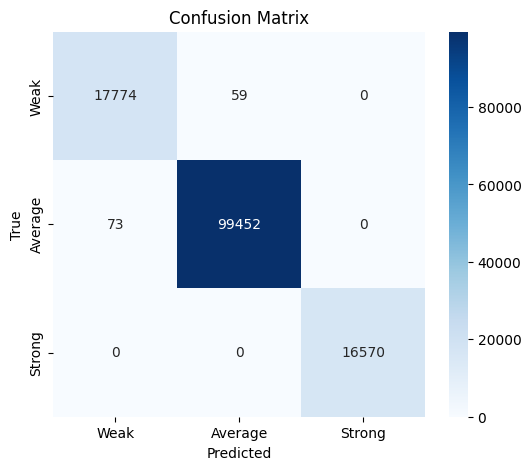

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


print(f'Total Test Samples: {total}')
print(f'Test Accuracy: {100 * correct / total:.2f}%')


print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=["Weak", "Average", "Strong"]))


cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Weak", "Average", "Strong"], yticklabels=["Weak", "Average", "Strong"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()